# Time-lapse creation using Sentinel-Hub Python packages

This Jupyter notebook shows how to use the SentinelHubTimelapse class to automatically generate time-lapses in *.gif and *.avi formats. User needs to provide a WMS instance ID, a bounding box and time range. The package uses our cloud detector to determine cloud coverage over the specified bounding-box, and removes time frames with cloud coverage greater than a user-specified threshold. Previews are available to avoid downloading of unwanted data.

##### Jupyter magic functions

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

##### General purpose imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np

##### Sentinl-Hub imports

In [4]:
from sentinelhub import BBox, CRS
from time_lapse import SentinelHubTimelapse

##### Set your WMS instance here

In [9]:
WMS_INSTANCE = ''

## Daxing Airport

This example show how to create a time-lapse of the construction of the [Daxing Airport](https://en.wikipedia.org/wiki/Beijing_Daxing_International_Airport) using Sentinel-2 images recorded over three years.

##### Set bounding box and time range

In [10]:
daxing_airport = BBox(bbox=[116.3287, 39.4651, 116.4935, 39.5366], 
                      crs=CRS.WGS84)
time_interval = ['2015-01-01', '2018-01-31']

Set size of full resolution images. In this case a format for generating .gifs and video to Twitter is used. Alternatively, one can provide `None` in place of the first or second argument and the other one is set automatically in a way that the image best fits the bounding box ratio 

In [11]:
tl_size = (int(1920/2),int(1080/2))

Create an instance of the SentinelHubTimelapse class with the specified parameters. Arguments of the class include ```full_size```, ```preview_size```, ```use_atmcor```, and ```time_difference```. Custom layers can be specified using the ```layers``` argument for the preview and full resolution images. The ```time_difference``` arguments specifies the time interval used to merge two or more requests.

In [12]:
daxing_timelapse = SentinelHubTimelapse('daxing-airport-twitter',
                                        daxing_airport, 
                                        time_interval, 
                                        WMS_INSTANCE,
                                        full_size=tl_size)

INFO:time_lapse:Found 203 images of daxing-airport-twitter between 2015-01-01 and 2018-01-31.
INFO:time_lapse:
I suggest you start by downloading previews first to see,
if BBOX is OK, images are usefull, etc...
Execute get_previews() method on your object.



Download and visualise previews of the images to ensure input settings are correct. Previews are saved locally into a ./previews/ folder 

In [13]:
daxing_timelapse.get_previews()
daxing_timelapse.plot_preview(filename='previews.pdf')

DownloadFailedException: Failed to download from:
https://services.sentinel-hub.com/ogc/wms/3a4d845f-48a2-42dd-b596-5f1be96cb985?SERVICE=wms&MAXCC=100.0&Transparent=True&BBOX=39.4651%2C116.3287%2C39.5366%2C116.4935&FORMAT=image%2Fpng&CRS=EPSG%3A4326&TIME=2015-08-07T03%3A16%3A26%2F2015-08-07T03%3A16%3A26&WIDTH=455&HEIGHT=256&LAYERS=TRUE_COLOR&REQUEST=GetMap&VERSION=1.3.0
with HTTPError:
400 Client Error: Bad Request for url: https://services.sentinel-hub.com/ogc/wms/3a4d845f-48a2-42dd-b596-5f1be96cb985?SERVICE=wms&MAXCC=100.0&Transparent=True&BBOX=39.4651%2C116.3287%2C39.5366%2C116.4935&FORMAT=image%2Fpng&CRS=EPSG%3A4326&TIME=2015-08-07T03%3A16%3A26%2F2015-08-07T03%3A16%3A26&WIDTH=455&HEIGHT=256&LAYERS=TRUE_COLOR&REQUEST=GetMap&VERSION=1.3.0
Server response: "Layer TRUE_COLOR not found"

Download full-resolution images

In [9]:
daxing_timelapse.save_fullres_images()

It is possible to remove images with invalid data, in cases where the image is taken on the border of the Sentinel-2 tile. The `max_invalid_coverage` is used to filter out images used in the time-lapse. In this example, images with an invalid area coverage greater than 1% are discarded.

In [10]:
daxing_timelapse.mask_invalid_images(max_invalid_coverage=0.01)

##### Apply Sentinel-Hub's cloud detector on full-res images

This step runs a classifier based on Gradient Boosting Machines, which was trained and tested internally. To use this classifier you need to install the Sentinel-Hub s2cloudless Python package. The ```max_cloud_coverage``` is used to filter out images used in the time-lapse. In this example, images with a cloud coverage greater than 1% are discarded.

In [11]:
daxing_timelapse.mask_cloudy_images(max_cloud_coverage=0.01)

INFO:time_lapse:Downloading cloud data and running cloud detection. This may take a while.


Visualise cloud masks and display cloud coverage as estimated by the classifier. Previews with a red tag are discarded from time-lapse. A ```binary``` colourmap is used, therefore clouds appear in black.

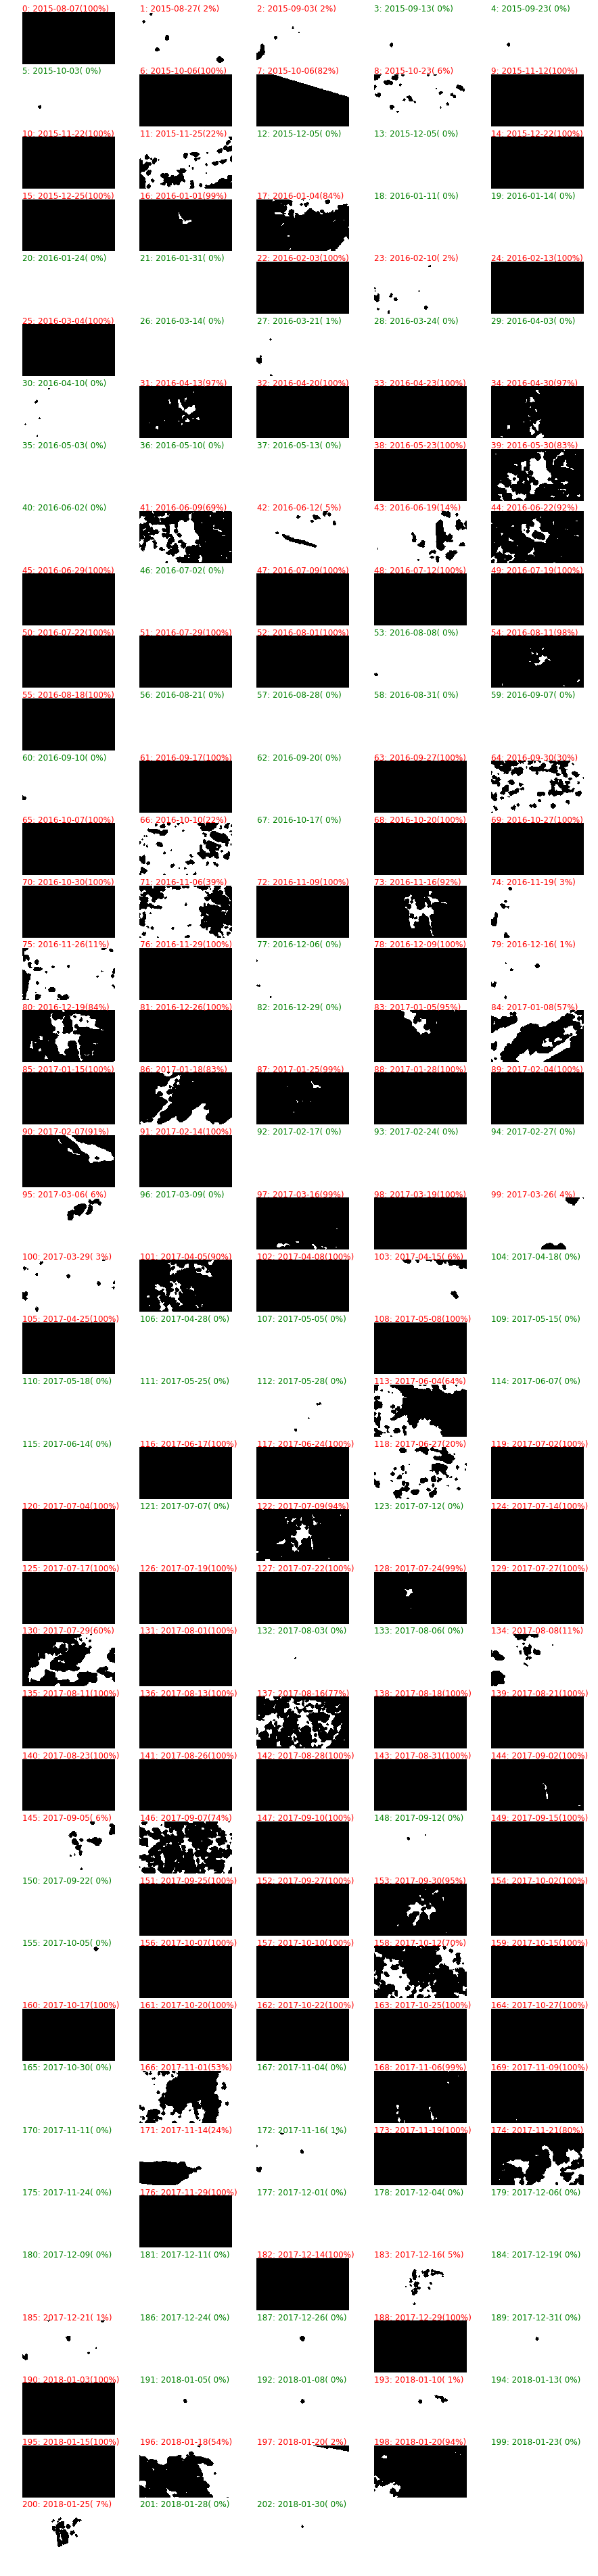

In [12]:
daxing_timelapse.plot_cloud_masks(filename='cloudmasks.pdf')

Preview cloud masks overlayed onto full-res images.  

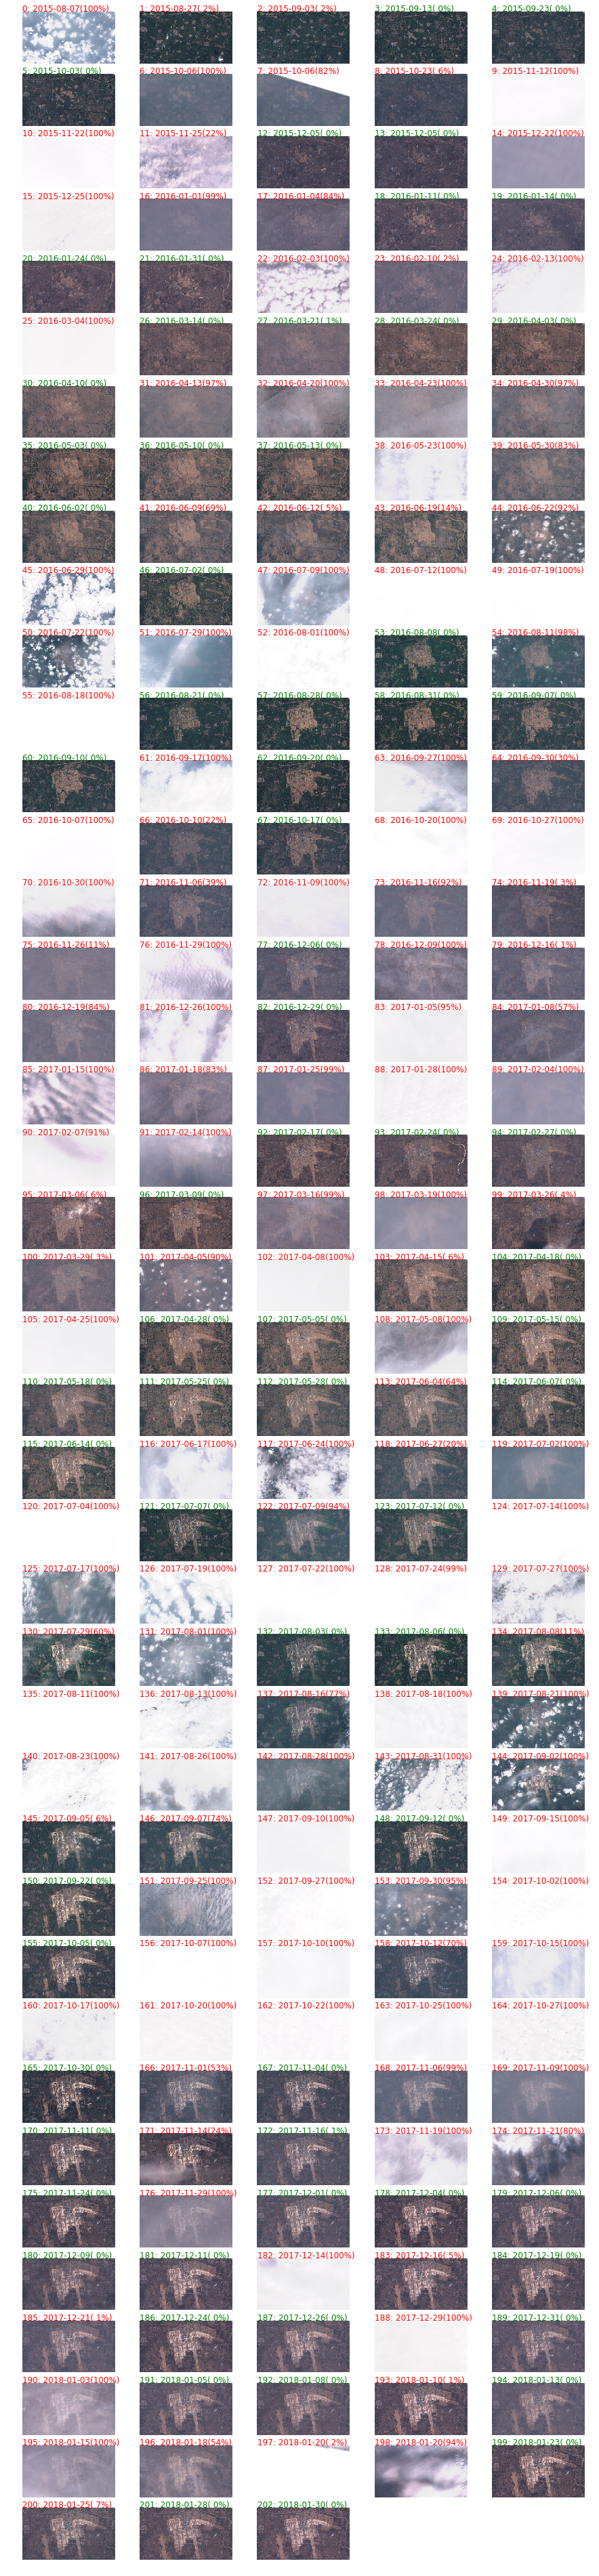

In [13]:
daxing_timelapse.plot_preview(filename='previews_with_cc.pdf')

Create date stamps to add to time-lapse

In [14]:
daxing_timelapse.create_date_stamps()
daxing_timelapse.create_timelapse(scale_factor=0.2)

##### Create time-lapse in gif format

A timelapse.gif will be created in the project folder. In this example, within the `daxing-airport-twitter` folder. Frames-per-second can be set via `fps` argument.

In [15]:
daxing_timelapse.make_gif(fps=8, filename='daxing_airport_8fps.gif')

##### Create time-lapse in *.avi format

In [16]:
daxing_timelapse.make_video(fps=10, filename='daxing_airport_10fps.avi')

### Manually filtering out frames

In some cases it may be necessary to manually mask or unmask individual images. This can be done using the `mask_images` or `unmask_images` method, where individual images are masked or unmasked based on their indices (as seen for example in the previews file).

In [17]:
mask_images = [191]
daxing_timelapse.mask_images(mask_images)
daxing_timelapse.create_date_stamps()
daxing_timelapse.create_timelapse(scale_factor=0.2)

Re-creating the time-lapse as gif and video with the manually specified frames leads to a better visual result.

In [18]:
daxing_timelapse.make_gif(fps=8)
daxing_timelapse.make_video(fps=12, filename='daxing_airport_12fps.avi')

##### Function wrapper

If you want to repeat the previous steps systematically, a wrapper function can be created as below.

In [19]:
def make_timelapse(msg, bbox, time_interval, *, full_size=(int(1920 / 4.1), int(1080 / 4.1)), mask_images=[],
                   max_cc=0.01, scale_factor=0.2, fps=8, instance_id=WMS_INSTANCE, **kwargs):
    timelapse = SentinelHubTimelapse(msg, bbox, time_interval, instance_id,
                                     full_size=full_size, **kwargs)
    timelapse.get_previews()
    timelapse.save_fullres_images()
    timelapse.plot_preview(filename='previews.pdf')
    timelapse.mask_cloudy_images(max_cloud_coverage=max_cc)
    timelapse.plot_cloud_masks(filename='cloudmasks.pdf')
    timelapse.plot_preview(filename='previews_with_cc.pdf')
    timelapse.mask_images(mask_images)
    timelapse.create_date_stamps()
    timelapse.create_timelapse(scale_factor=scale_factor)

    timelapse.make_gif(fps=fps)
    timelapse.make_video(fps=fps)

The following examples use this wrapper function to create time-lapses in few lines of code.

## Sahara Pivot Irrigation Fields

Time-lapse example of [Pivot Irrigation Fields](https://en.wikipedia.org/wiki/Center_pivot_irrigation) in the Sahara desert.

In [ ]:
sahara_fields = BBox(bbox=[6.6574, 33.3352, 6.7453, 33.3719],
                     crs=CRS.WGS84)

mask_idxs = [7, 96, 112, 170, 186, 190]

make_timelapse(msg='sahara-fields-mediumres', bbox=sahara_fields, time_interval=time_interval,
               mask_images=mask_idxs, max_cc=0.1, scale_factor=0.2)

## Folsom lake

Time-lapse example of the [Folsom lake](https://en.wikipedia.org/wiki/Folsom_Lake) in California, USA.

In [ ]:
folsom_lake = BBox(bbox=[-121.2654, 38.6938, -120.9138, 38.8309],
                   crs=CRS.WGS84)

make_timelapse(msg='folsom-mediumres', bbox=folsom_lake, time_interval=time_interval, max_cc=0.1)